                  RSI   R_EMA50   R_EMA20     Lag50       MACD      Volume  \
Date                                                                         
2000-10-17  32.525658 -0.002521 -0.004155 -8.743881 -29.465005  1161500000   

              Vol_EMA200   BB_pctB        ADX       +DI        -DI       ATR  \
Date                                                                           
2000-10-17  9.974028e+08  0.066411  37.330168  8.327433  35.698611  26.50824   

                 ROC        W%R  Month  
Date                                    
2000-10-17 -5.362225 -82.995307     10  


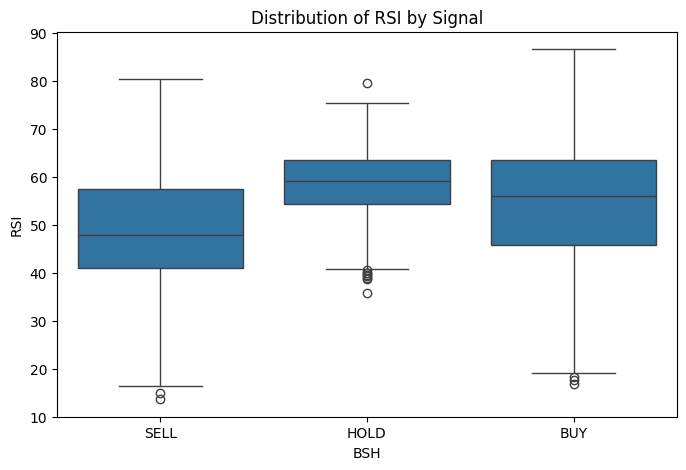

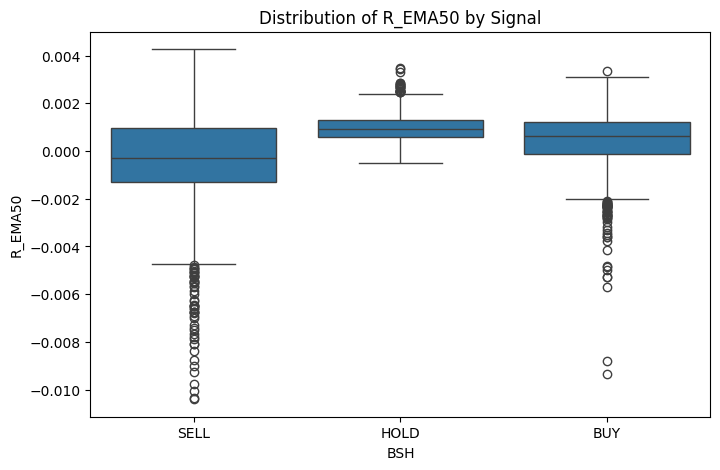

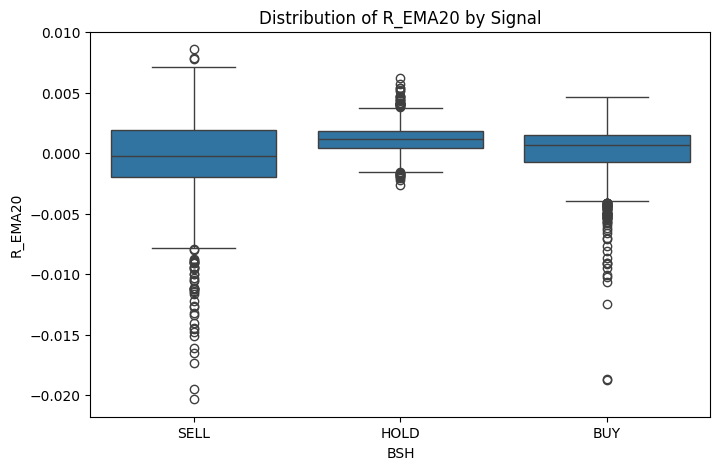

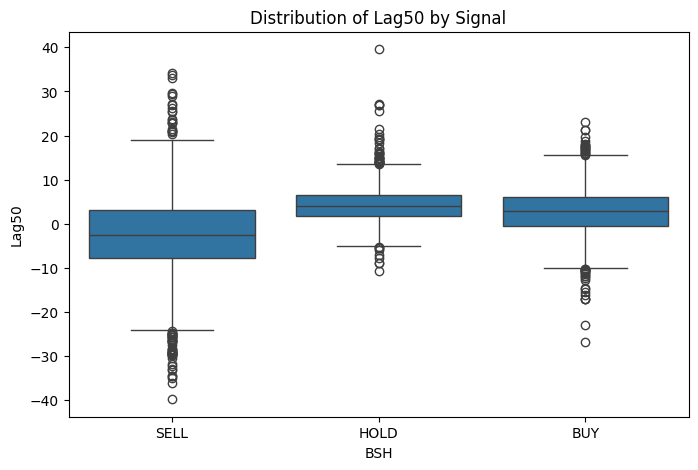

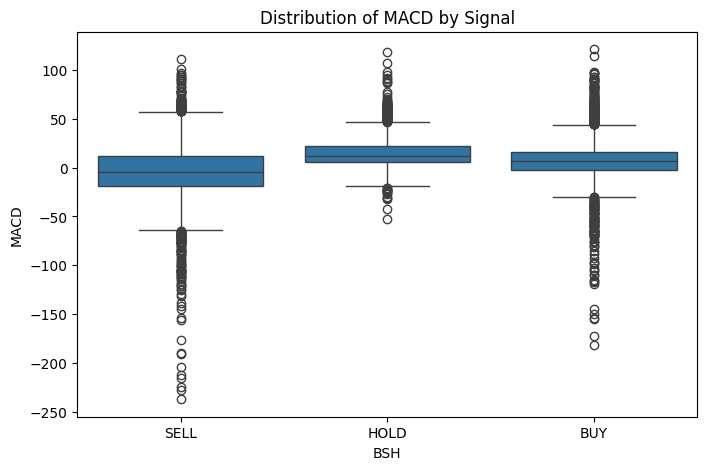

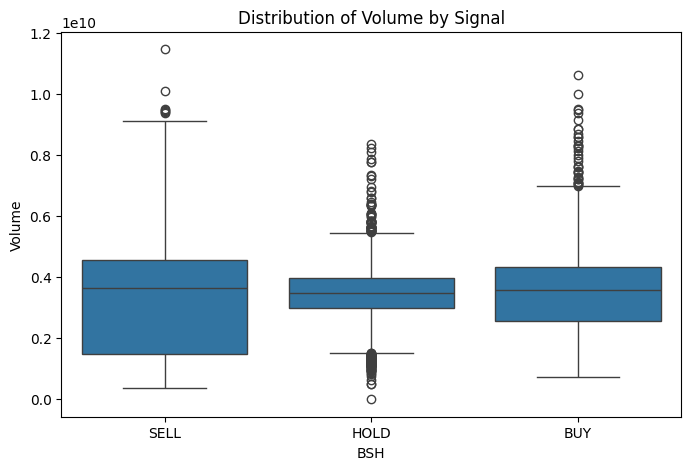

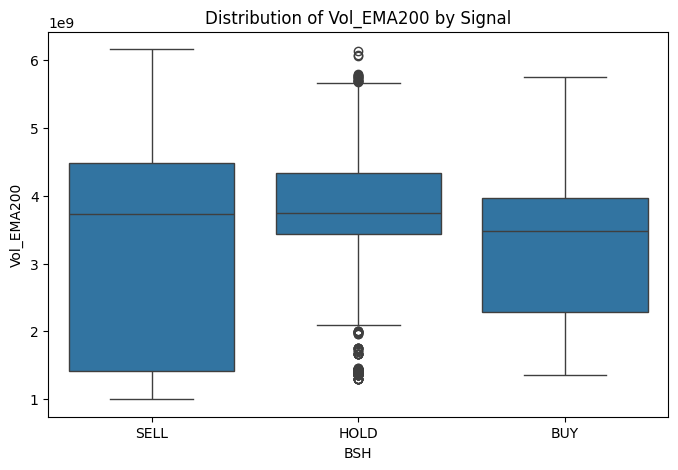

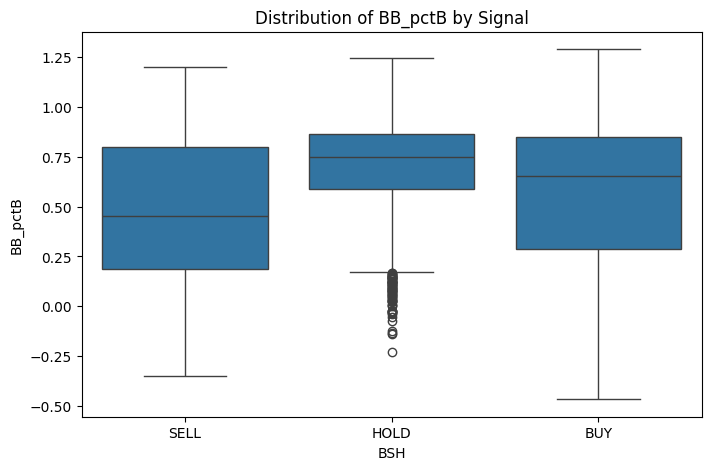

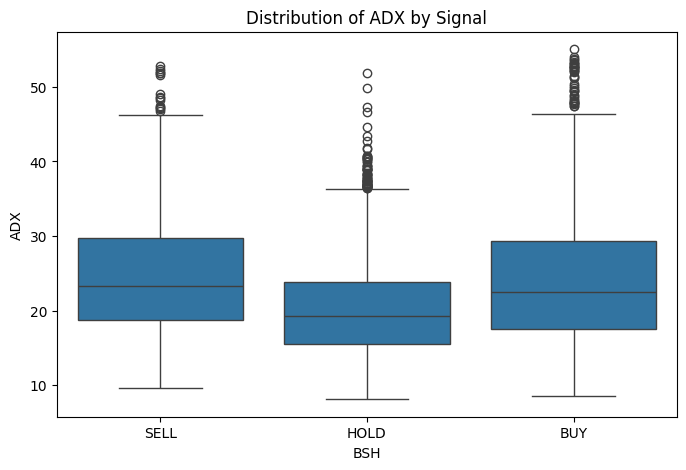

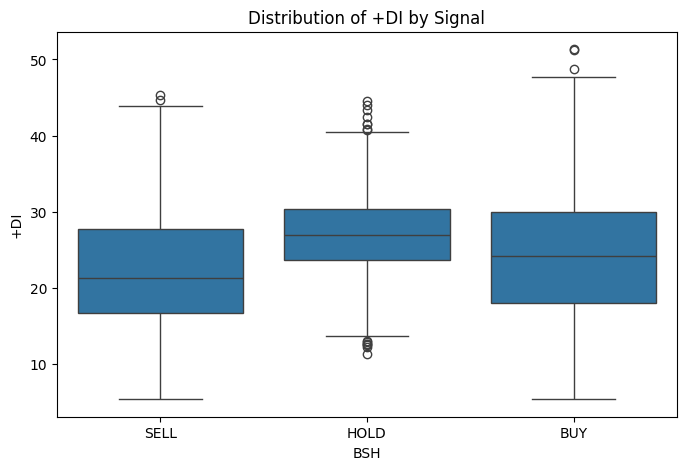

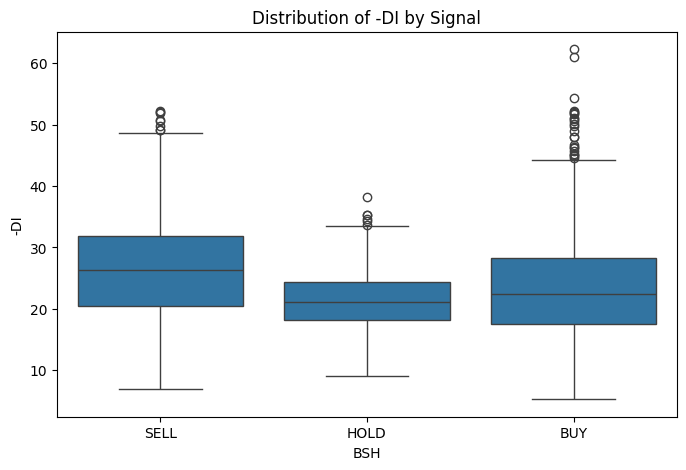

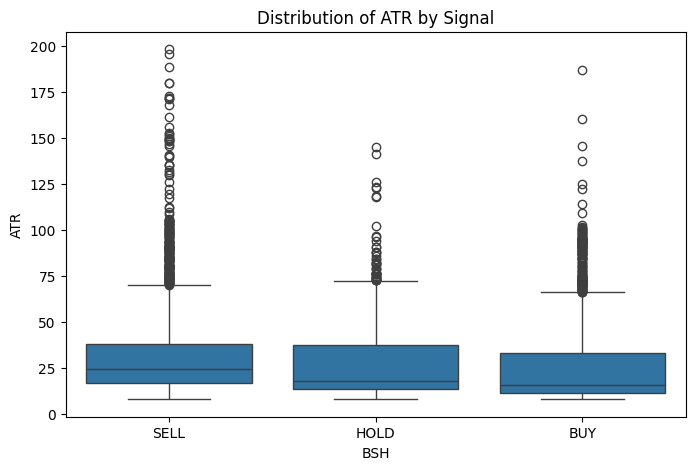

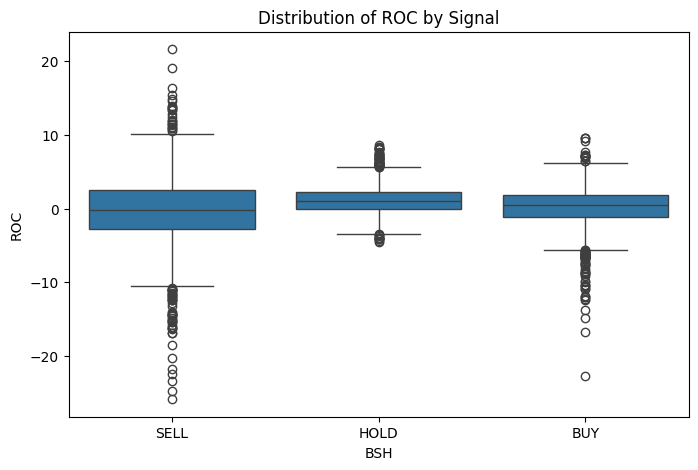

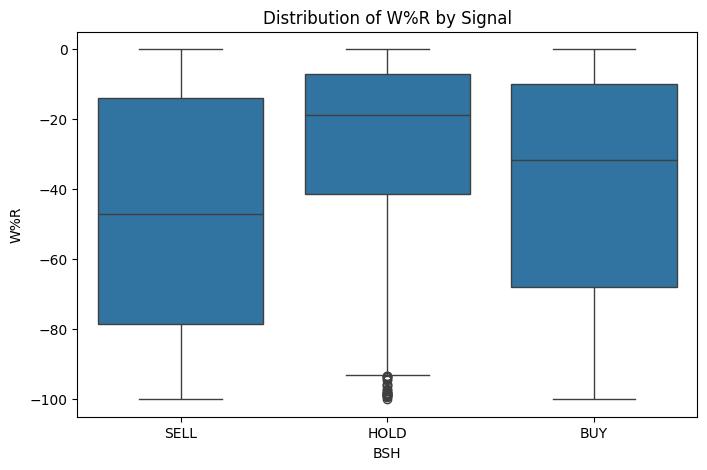

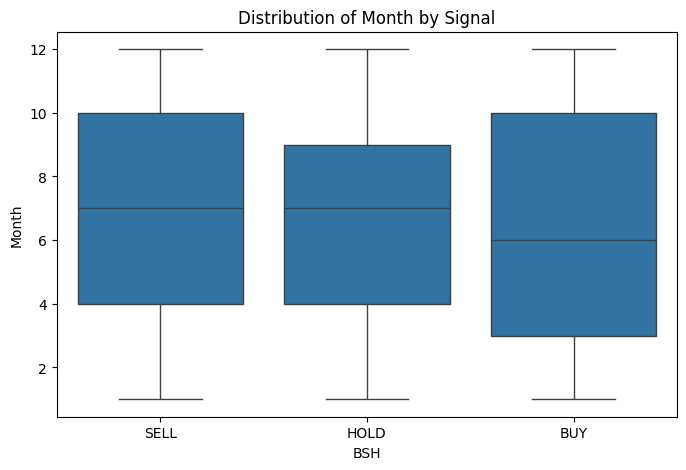

In [47]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier



TICKER = "^GSPC"

# --- Carica dati ---
df = pd.read_csv(
    f"csv/{TICKER}_indicators.csv",
    index_col=0,
    parse_dates=[0],
    date_format="ISO8601"
)

#features = ["Lag1", "Lag10", "Lag15", "Lag50", "R_EMA50", "R_EMA10"]
features = ["RSI","R_EMA50","R_EMA20","Lag50","MACD","Volume","Vol_EMA200","BB_pctB",
            "ADX","+DI","-DI","ATR","ROC","W%R","Month"]

#features = [
#    "RSI", "R_EMA50", "R_EMA20", "Lag10", "Lag50",
#    "MACD", "MACD_Signal", "Volume", "Vol_EMA50", "Vol_EMA200",
#    "BB_pctB", "ADX", "+DI", "-DI", "ATR", "W%R"
#]

# --- Features e target ---
X = df[features]
y = df["BSH"]

print(X.head(1))


for feat in features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=y, y=df[feat])  # y = your labels (BUY/SELL/HOLD)
    plt.title(f"Distribution of {feat} by Signal")
    plt.show()



In [48]:
# Split temporale train/test
X.index = pd.to_datetime(X.index)

cutoff = pd.to_datetime("2025-01-01")
train_mask = X.index < cutoff
test_mask = X.index >= cutoff

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]


bsh_counts = y_test.value_counts()
print(f"  Conteggio etichette per il test di {TICKER}:")
print(bsh_counts)
print(f"  Totale righe: {len(df)}")
print("-" * 40)

  Conteggio etichette per il test di ^GSPC:
BSH
BUY     127
HOLD     33
SELL     28
Name: count, dtype: int64
  Totale righe: 6277
----------------------------------------


[0.52380952 0.66174056 0.64039409 0.71264368 0.56321839 0.5681445
 0.57963875 0.55993432 0.60262726 0.53618421]


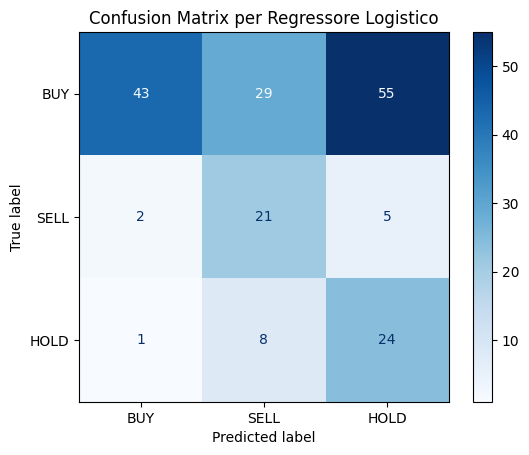

Classification report per Regressione Logistica:
              precision    recall  f1-score   support

         BUY       0.93      0.34      0.50       127
        SELL       0.36      0.75      0.49        28
        HOLD       0.29      0.73      0.41        33

    accuracy                           0.47       188
   macro avg       0.53      0.61      0.47       188
weighted avg       0.74      0.47      0.48       188



In [49]:
# Standardizzazione
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tentativo fallimentare di Oversampling
#smote = SMOTE(random_state=42)
#X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

#print("Class distribution after SMOTE:")
#print(pd.Series(y_res).value_counts())

# --- Logistic Regression ---
softmax_reg = LogisticRegression(max_iter=2000,solver="lbfgs",random_state=42)

print(cross_val_score(softmax_reg,X_train_scaled,y_train,cv=10,scoring="accuracy"))
softmax_reg.fit(X_train_scaled, y_train)

# Predizioni
y_pred = softmax_reg.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred, labels=["BUY","SELL","HOLD"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["BUY","SELL","HOLD"])
disp.plot(cmap = "Blues")
plt.title("Confusion Matrix per Regressore Logistico")
plt.show()

# Report di classificazione
print("Classification report per Regressione Logistica:")
print(classification_report(y_test, y_pred, labels=["BUY","SELL","HOLD"]))


Testing degli iperparametri su Random Forest

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [8, 12, 16, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2"]
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_macro",   # optimize for F1 instead of accuracy
    cv=5,                 # 5-fold cross-validation
    n_jobs=-1,            # run in parallel
    verbose=2
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Cross-val scores (RF):
[0.39901478 0.63711002 0.47783251 0.50738916 0.30049261 0.42857143
 0.3908046  0.40722496 0.50574713 0.57730263]


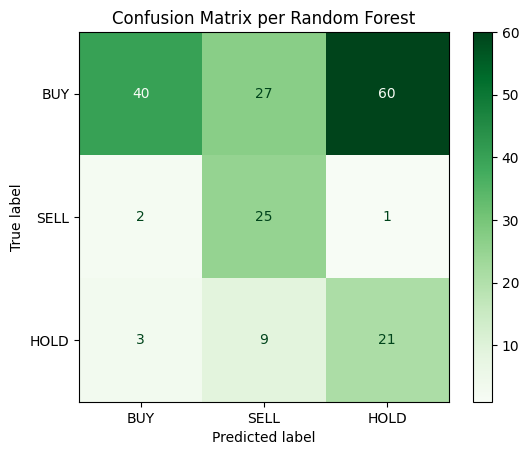

Classification report (Random Forest):
              precision    recall  f1-score   support

         BUY       0.89      0.31      0.47       127
        SELL       0.41      0.89      0.56        28
        HOLD       0.26      0.64      0.37        33

    accuracy                           0.46       188
   macro avg       0.52      0.61      0.46       188
weighted avg       0.71      0.46      0.46       188



In [50]:
# --- Random Forest ---
rf = RandomForestClassifier(
    n_estimators=300,      
    max_depth=None,        
    random_state=42,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features="sqrt",
    n_jobs=-1
)

# forests don’t need scaling, so use raw X_train, X_test
print("Cross-val scores (RF):")
print(cross_val_score(rf, X_train, y_train, cv=10, scoring="accuracy"))

rf.fit(X_train, y_train)

# Predizioni
y_pred_rf = rf.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=["BUY","SELL","HOLD"])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["BUY","SELL","HOLD"])
disp_rf.plot(cmap="Greens")
plt.title("Confusion Matrix per Random Forest")
plt.show()

# Report di classificazione
print("Classification report (Random Forest):")
print(classification_report(y_test, y_pred_rf, labels=["BUY","SELL","HOLD"]))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3583
[LightGBM] [Info] Number of data points in the train set: 6089, number of used features: 15
[LightGBM] [Info] Start training from score -1.095497
[LightGBM] [Info] Start training from score -1.157811
[LightGBM] [Info] Start training from score -1.045678


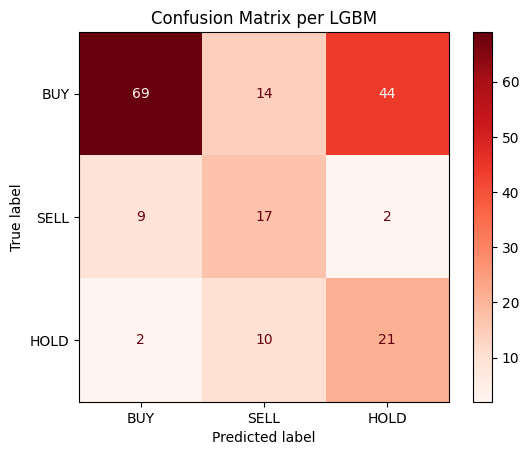

Classification Report per LGBM:
              precision    recall  f1-score   support

         BUY       0.86      0.54      0.67       127
        HOLD       0.31      0.64      0.42        33
        SELL       0.41      0.61      0.49        28

    accuracy                           0.57       188
   macro avg       0.53      0.60      0.53       188
weighted avg       0.70      0.57      0.60       188



In [51]:
lgbm = LGBMClassifier(
    n_estimators=200,
    max_depth=-1,          # no depth limit, trees controlled by leaves
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

# -----------------------------
# Evaluation
# -----------------------------
y_pred = lgbm.predict(X_test)


# Confusion matrix
cm_rf = confusion_matrix(y_test, np.asarray(y_pred), labels=["BUY","SELL","HOLD"])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["BUY","SELL","HOLD"])
disp_rf.plot(cmap="Reds")
plt.title("Confusion Matrix per LGBM")
plt.show()


print("Classification Report per LGBM:")
print(classification_report(y_test, np.asarray(y_pred)))

In [52]:
# Export model code
import joblib

SavedName = f"rf_{TICKER}_v1.joblib"

# Selezionare la variabile del modello da estrarre
bundle = {
    "model": rf,
    # add scaler if needed "scaler": scaler
    "features": features 
}
#joblib.dump(bundle, f"models/{SavedName}")

